In [ ]:
"""
Hybrid BO on the Franke surface: Random vs Baseline EI vs Dynamic-Prior + Curated Pool
=====================================================================================

What this script provides
-------------------------
- **Random**: uniform sampling over [0,1]^2.
- **Baseline BO (EI)**: standard SingleTaskGP + analytic EI (no prior).
- **Hybrid (this work)**: residual GP + **dynamic prior shaping** (m0 weight updates, optional 2D bumps)
  **and** a **curated candidate pool** per-iteration (anchors + Sobol candidates) where EI is evaluated.

Design notes
------------
- Minimal, modular, and self-contained (no external LLM call). A single stub `controller_decide(...)` can later
  be swapped for an actual LLM; its outputs already match the intended API.
- Prior mean m0(x) is implemented in torch and can include variable effects **and** a list of 2D Gaussian "bumps".
- Residual fitting uses least-squares calibration of α so the prior magnitude matches observed data scale; a
  per-iteration **m0_weight** gates the prior influence: `m0_scale = α * m0_weight`.
- The curated pool blends Sobol points with a few controller-proposed **anchors** (e.g., near incumbent and
  high-uncertainty zones). EI is evaluated on the pool; we pick the argmax (no gradient refine to keep code simple).

Usage (Jupyter)
---------------
```python
hist = compare_methods(n_init=6, n_iter=25, seed=0)
plot_runs(hist)
# or aggregate over seeds
hist_all = run_many_seeds(seeds=list(range(5)), n_init=6, n_iter=25)
plot_runs_mean(hist_all)
```

Dependencies
------------
- torch >=1.11, botorch, gpytorch, numpy, pandas, matplotlib
"""

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd

import torch
from torch import Tensor

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch.posteriors.gpytorch import GPyTorchPosterior
from botorch.utils.sampling import draw_sobol_samples

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from bo_anchor_prompts import SYS_PROMPT_ANCHORING_V2, FEW_SHOT_EXAMPLES



import httpx 
from openai import OpenAI
_OPENAI_CLIENT = OpenAI(http_client=httpx.Client(verify=False))


# -------------------- Device / dtype --------------------
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DTYPE = torch.float32
torch.set_default_dtype(DTYPE)

# -------------------- Franke surface --------------------

def franke_np(xy: np.ndarray) -> np.ndarray:
    x, y = xy[:, 0], xy[:, 1]
    t1 = 0.75 * np.exp(-(9*x - 2)**2 / 4.0 - (9*y - 2)**2 / 4.0)
    t2 = 0.75 * np.exp(-(9*x + 1)**2 / 49.0 - (9*y + 1)**2 / 10.0)
    t3 = 0.50 * np.exp(-(9*x - 7)**2 / 4.0 - (9*y - 3)**2 / 4.0)
    t4 = 0.20 * np.exp(-(9*x - 4)**2 - (9*y - 7)**2)
    return t1 + t2 + t3 - t4


def franke_torch(X: Tensor, noise_sd: float = 0.0) -> Tensor:
    x, y = X[..., 0], X[..., 1]
    t1 = 0.75 * torch.exp(-(9*x - 2)**2 / 4.0 - (9*y - 2)**2 / 4.0)
    t2 = 0.75 * torch.exp(-(9*x + 1)**2 / 49.0 - (9*y + 1)**2 / 10.0)
    t3 = 0.50 * torch.exp(-(9*x - 7)**2 / 4.0 - (9*y - 3)**2 / 4.0)
    t4 = 0.20 * torch.exp(-(9*x - 4)**2 - (9*y - 7)**2)
    f = t1 + t2 + t3 - t4
    if noise_sd > 0.0:
        f = f + noise_sd * torch.randn_like(f)
    return f.unsqueeze(-1)

# -------------------- Harder variant of Franke --------------------

def _rotate_anisowarp_torch(X: Tensor, center=(0.5, 0.5), deg: float = 35.0, scale=(1.0, 0.35)) -> Tensor:
    cx, cy = float(center[0]), float(center[1])
    th = math.radians(deg)
    R = torch.tensor([[math.cos(th), -math.sin(th)],
                      [math.sin(th),  math.cos(th)]], device=X.device, dtype=X.dtype)
    S = torch.tensor([[scale[0], 0.0],[0.0, scale[1]]], device=X.device, dtype=X.dtype)
    Xc = X - torch.tensor([cx, cy], device=X.device, dtype=X.dtype)
    return (Xc @ R.t()) @ S.t() + torch.tensor([cx, cy], device=X.device, dtype=X.dtype)


def franke_hard_torch(
    X: Tensor,
    noise_sd: float = 0.0,
    rotate_deg: float = 35.0,
    anisotropy: Tuple[float,float] = (1.0, 0.35),
    ripple_amp: float = 0.10,
    ripple_freq: Tuple[int,int] = (5,7),
    distractor_amp: float = 0.25,
    distractor_mu: Tuple[float,float] = (0.78, 0.82),
    distractor_sigma: float = 0.035,
    ridge_depth: float = 0.12,
    ridge_dir: Tuple[float,float] = (0.8, -0.6),
    ridge_sigma: float = 0.025,
    clip01: bool = True,
) -> Tensor:
    # 1) Warp: rotate + anisotropic scale (non-axis aligned structure)
    Xw = _rotate_anisowarp_torch(X, deg=rotate_deg, scale=anisotropy)
    base = franke_torch(Xw, noise_sd=0.0).squeeze(-1)

    # 2) Add periodic ripples to create many local optima
    kx, ky = ripple_freq
    rip = ripple_amp * torch.sin(2*math.pi*kx*X[...,0]) * torch.sin(2*math.pi*ky*X[...,1])

    # 3) Add a sharp distractor peak away from the global mode
    mu = torch.tensor(distractor_mu, device=X.device, dtype=X.dtype)
    d = torch.exp(-0.5 * torch.sum(((X - mu)/distractor_sigma)**2, dim=-1))
    dist = distractor_amp * d

    # 4) Subtract a thin ridge valley (hard barrier to cross)
    v = torch.tensor(ridge_dir, device=X.device, dtype=X.dtype)
    v = v / torch.norm(v)
    proj = torch.sum((X - 0.5) * v, dim=-1)
    ridge = -ridge_depth * torch.exp(-0.5 * (proj / ridge_sigma)**2)

    f = base + rip + dist + ridge

    if clip01:
        # keep output numerically reasonable without hard clipping to [0,1]
        fmin, fmax = f.min().item(), f.max().item()
        f = torch.clamp(f, min=fmin, max=fmax)

    if noise_sd > 0.0:
        # heteroscedastic noise (stronger near ripple maxima)
        het = 0.5 + 0.5*torch.abs(torch.sin(2*math.pi*X[...,0]))*torch.abs(torch.sin(2*math.pi*X[...,1]))
        f = f + noise_sd * het * torch.randn_like(f)

    return f.unsqueeze(-1)

# -------------------- Minimal prior ---------------------

@dataclass
class Prior:
    # Per-variable effects (optional). Example structure:
    # effects = {"x1": {"effect":"nonmonotone-peak","scale":0.6,"confidence":0.7,"range_hint":[0.2,0.3]}, ...}
    effects: Dict[str, Dict[str, Any]]
    # Pairwise interactions (optional), e.g., [{"pair":["x1","x2"],"type":"synergy","confidence":0.5}]
    interactions: List[Dict[str, Any]]
    # List of 2D Gaussian bumps: [{"mu":[x1,x2], "sigma":0.15, "amp":0.2}, ...]
    bumps: List[Dict[str, Any]]

    def m0_torch(self, X: Tensor) -> Tensor:
        # Variables are x1,x2 in [0,1]
        z1, z2 = X[..., 0], X[..., 1]
        out = torch.zeros(X.shape[:-1], device=X.device, dtype=X.dtype)

        def _sigmoid(z, k: float = 6.0):
            return 1.0 / (1.0 + torch.exp(-k * (z - 0.5)))

        def _gauss1d(z, mu: float, s: float):
            return torch.exp(-0.5 * ((z - mu) / (s + 1e-12)) ** 2)

        # Per-variable effects
        for name, spec in self.effects.items():
            eff = spec.get("effect", "flat")
            sc = float(spec.get("scale", 0.0))
            conf = float(spec.get("confidence", 0.0))
            rh = spec.get("range_hint", None)
            amp = 0.6 * sc * conf  # keep m0 on ~[0,1] scale
            if amp == 0.0:
                continue
            mu = 0.5
            if isinstance(rh, (list, tuple)) and len(rh) == 2:
                mu = 0.5 * (float(rh[0]) + float(rh[1]))
            z = z1 if name == "x1" else z2
            if eff == "increase":
                out = out + amp * _sigmoid(z)
            elif eff == "decrease":
                out = out - amp * _sigmoid(z)
            elif eff == "nonmonotone-peak":
                out = out + amp * _gauss1d(z, mu=mu, s=0.18)
            elif eff == "nonmonotone-valley":
                out = out - amp * _gauss1d(z, mu=mu, s=0.18)
            # "flat" -> no change

        # Simple bilinear interaction (normalized)
        for it in self.interactions:
            pair = it.get("pair", [])
            if pair == ["x1", "x2"] or pair == ["x2", "x1"]:
                sign = 1.0 if it.get("type", "synergy") == "synergy" else -1.0
                conf = float(it.get("confidence", 0.0))
                out = out + 0.2 * sign * conf * (z1 * z2)

        # 2D bumps
        for b in self.bumps:
            mu = torch.tensor(b.get("mu", [0.5, 0.5]), device=X.device, dtype=X.dtype)
            sig = float(b.get("sigma", 0.15))
            amp = float(b.get("amp", 0.1))
            out = out + amp * torch.exp(-0.5 * torch.sum(((X - mu) / sig) ** 2, dim=-1))
        return out

# -------------------- Residual GP wrapper ----------------

class GPWithPriorMean(gpytorch.models.ExactGP):
    # Thin wrapper around a residual GP that returns total posterior m0 + g
    def __init__(self, base_gp: SingleTaskGP, prior: Prior, m0_scale: float = 1.0):
        self.base_gp = base_gp
        self.prior = prior
        self.m0_scale = float(m0_scale)

    @property
    def num_outputs(self) -> int:
        return 1

    def posterior(self, X: Tensor, observation_noise: bool = False, **kwargs) -> GPyTorchPosterior:
        base_post = self.base_gp.posterior(X, observation_noise=observation_noise, **kwargs)
        mvn = base_post.mvn
        m0 = self.prior.m0_torch(X).reshape(mvn.mean.shape)
        new_mvn = MultivariateNormal(mean=mvn.mean + self.m0_scale * m0, covariance_matrix=mvn.covariance_matrix)
        return GPyTorchPosterior(new_mvn)

    # delegate common ops
    def condition_on_observations(self, X: Tensor, Y: Tensor, noise: Optional[Tensor] = None, **kwargs):
        cm = self.base_gp.condition_on_observations(X=X, Y=Y, noise=noise, **kwargs)
        return GPWithPriorMean(base_gp=cm, prior=self.prior, m0_scale=self.m0_scale)

# -------------------- Utilities -------------------------

def fit_residual_gp(X: Tensor, Y: Tensor, prior: Prior) -> Tuple[SingleTaskGP, float]:
    # LS-calibrate alpha between prior m0 and Y, then fit GP on residuals
    m0 = prior.m0_torch(X).reshape(-1)
    yv = Y.reshape(-1)
    m0c = m0 - m0.mean()
    yc = yv - yv.mean()
    denom = torch.dot(m0c, m0c).item()
    alpha = (torch.dot(m0c, yc).item() / (denom + 1e-12)) if denom > 0 else 0.0
    Y_resid = Y - alpha * m0.unsqueeze(-1)
    gp = SingleTaskGP(X, Y_resid).to(DEVICE)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp).to(DEVICE)
    fit_gpytorch_mll(mll)
    return gp, alpha


def alignment_on_obs(X: Tensor, Y: Tensor, prior: Prior) -> float:
    m0 = prior.m0_torch(X).reshape(-1)
    yv = Y.reshape(-1)
    m0c = m0 - m0.mean()
    yc = yv - yv.mean()
    num = torch.dot(m0c, yc).item()
    den = torch.sqrt(torch.dot(m0c, m0c) * torch.dot(yc, yc) + 1e-12).item()
    return num / den if den > 0 else 0.0

# -------------------- Controller (stub) ------------------

@dataclass
class Telemetry:
    t: int
    best: float
    imp_last_k: float
    rho: float
    alpha_ls: float

@dataclass
class Action:
    m0_weight: float                # in [0,1]
    anchors: List[List[float]]      # list of [x1,x2]
    add_bump: Optional[Dict[str, Any]] = None


def controller_decide(tele: Telemetry, X: Tensor, Y: Tensor, prior: Prior, gp_resid: SingleTaskGP) -> Action:
    # Rule-based placeholder for an LLM policy.
    # Strategy:
    # - downweight prior if misaligned; upweight if aligned
    # - if stagnating, propose anchors near incumbent and high-variance zones
    # - optionally add a small bump at incumbent to bias search locally
    if tele.rho < 0.0:
        w = 0.0
    elif tele.rho < 0.2:
        w = 0.3
    else:
        w = min(1.0, 0.5 + 0.4 * tele.rho)

    # incumbent
    ibest = int(torch.argmax(Y))
    x_star = X[ibest].detach().cpu().tolist()

    # variance-based anchors on a coarse grid
    with torch.no_grad():
        grid = draw_sobol_samples(bounds=torch.stack([torch.zeros(2, device=DEVICE, dtype=DTYPE),
                                                      torch.ones(2, device=DEVICE, dtype=DTYPE)]),
                                   n=256, q=1).squeeze(1).to(DEVICE)
        post = gp_resid.posterior(grid)
        var = post.variance.reshape(-1)
        topk = torch.topk(var, k=3).indices
    anchors = [x_star] + [grid[i].detach().cpu().tolist() for i in topk]

    bump = None
    if tele.imp_last_k < 1e-3 and tele.rho > 0.0:
        bump = {"mu": x_star, "sigma": 0.12, "amp": 0.12}

    return Action(m0_weight=float(w), anchors=anchors, add_bump=bump)




# --- Anchor utilities: spacing + posterior context for the LLM ---

def enforce_min_spacing(points: List[List[float]], min_dist: float) -> List[List[float]]:
    if not points or (min_dist is None) or (min_dist <= 0.0):
        return points
    kept: List[List[float]] = []
    r2 = float(min_dist) * float(min_dist)
    for p in points:
        ok = True
        for q in kept:
            dx, dy = p[0] - q[0], p[1] - q[1]
            if dx*dx + dy*dy < r2:
                ok = False; break
        if ok:
            kept.append([float(min(max(p[0], 0.0), 1.0)), float(min(max(p[1], 0.0), 1.0))])
    return kept


def make_ei_context(gp: SingleTaskGP, X: Tensor, Y: Tensor, bounds: Tensor,
                    grid_n: int = 20, topk: int = 5) -> Dict[str, Any]:
    # Small, structured summary the LLM can reason with
    with torch.no_grad():
        xs = torch.linspace(0, 1, grid_n, device=DEVICE, dtype=DTYPE)
        xx, yy = torch.meshgrid(xs, xs, indexing="xy")
        grid = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

        post = gp.posterior(grid.unsqueeze(1))  # q=1
        var = post.variance.reshape(-1)

        best_f = float(Y.max().item())
        EI = ExpectedImprovement(model=gp, best_f=best_f, maximize=True)
        ei_vals = EI(grid.unsqueeze(1)).reshape(-1)

        k1 = min(topk, ei_vals.numel()); k2 = min(topk, var.numel())
        top_ei = grid[torch.topk(ei_vals, k=k1).indices].detach().cpu().tolist()
        top_var = grid[torch.topk(var, k=k2).indices].detach().cpu().tolist()
        inc = X[int(torch.argmax(Y))].detach().cpu().tolist()

        lsc = None
        if hasattr(gp.covar_module, 'base_kernel') and hasattr(gp.covar_module.base_kernel, 'lengthscale'):
            l = gp.covar_module.base_kernel.lengthscale.detach().view(-1).cpu().tolist()
            lsc = l[:2] if len(l) >= 2 else l

        mu_X = gp.posterior(X.unsqueeze(1)).mean.squeeze(-1)
        res = (Y.squeeze(-1) - mu_X).detach().cpu().numpy()
        pos_frac = float((res > 0).mean()); neg_frac = float((res < 0).mean())

        H, _, _ = np.histogram2d(X[:,0].cpu().numpy(), X[:,1].cpu().numpy(),
                                 bins=grid_n, range=[[0,1],[0,1]])
        return {
            "grid_n": grid_n,
            "top_ei": top_ei,
            "top_var": top_var,
            "incumbent": inc,
            "lengthscales": lsc,
            "residual_sign": {"pos_frac": pos_frac, "neg_frac": neg_frac},
            "density": H.astype(int).tolist(),
        }




# -------- LLM-based anchors with policy (roles, spacing, trust-region) --------

def llm_propose_anchors(
    history_df: pd.DataFrame,
    k: int = 5,
    context: Dict[str, Any] = None,
    sys_prompt: str = SYS_PROMPT_ANCHORING_V2,
    few_shots: Optional[List[Dict[str, Any]]] = None,
):
    """Return dict: {"anchors": [[x1,x2],...], "min_spacing": float,
                     "trust_region": [[l1,h1],[l2,h2]]} or [] on failure."""
    if _OPENAI_CLIENT is None:
        return []
    import json

    tail = history_df.tail(50).copy() if (history_df is not None and not history_df.empty) else pd.DataFrame()
    cols = ["iter", "x1", "x2", "y", "best_so_far", "method"]
    if not tail.empty and all(c in tail.columns for c in cols):
        tail = tail[cols]

    user_payload = {
        "K": k,
        "recent_history_csv": tail.to_csv(index=False) if not tail.empty else "",
        "context": context or {},
        "rules": {"min_spacing_default": 0.08, "inside_bounds": [0.0, 1.0], "avoid_duplicates": True},
    }

    import json

    messages = [{"role": "system", "content": sys_prompt}]

    # Optional few-shots (as strict JSON strings)
    if few_shots:
        for ex in few_shots:
            messages.append({"role": "user", "content": json.dumps(ex["user"])})
            messages.append({"role": "assistant", "content": json.dumps(ex["assistant"])})

    messages.append({"role": "user", "content": json.dumps(user_payload)})

    resp = _OPENAI_CLIENT.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.2,
        response_format={"type": "json_object"},
        messages=messages,
    )


    try:
        data = json.loads(resp.choices[0].message.content)
        anchors_out, roles = [], []
        for a in data.get("anchors", [])[:k]:
            if isinstance(a, dict) and "x" in a and isinstance(a["x"], (list, tuple)) and len(a["x"]) == 2:
                x1 = float(min(max(a["x"][0], 0.0), 1.0)); x2 = float(min(max(a["x"][1], 0.0), 1.0))
                anchors_out.append([x1, x2]); roles.append(a.get("role", "unspecified"))
            elif isinstance(a, (list, tuple)) and len(a) == 2:
                anchors_out.append([float(min(max(a[0],0.0),1.0)), float(min(max(a[1],0.0),1.0))])

        min_spacing = float(data.get("min_spacing", 0.08) or 0.08)
        tr = data.get("trust_region", None)
        return {"anchors": anchors_out, "min_spacing": min_spacing, "trust_region": tr, "roles": roles}
    except Exception:
        return []


# -------------------- Methods ---------------------------

def run_random(n_evals: int, seed: int = 0, noise_sd: float = 0.0, obj=franke_torch) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    X = torch.from_numpy(rng.random((n_evals, 2))).to(DEVICE, DTYPE)
    Y = obj(X, noise_sd=noise_sd)
    best = -1e9
    rec = []
    for t in range(n_evals):
        best = max(best, float(Y[:t+1].max().item()))
        rec.append({"iter": t, "x1": float(X[t,0]), "x2": float(X[t,1]), "y": float(Y[t].item()), "best_so_far": best, "method": "random"})
    return pd.DataFrame(rec)


def run_baseline_ei(n_init: int, n_iter: int, seed: int = 0, noise_sd: float = 0.0, obj=franke_torch) -> pd.DataFrame:
    torch.manual_seed(seed)
    if USE_CUDA: torch.cuda.manual_seed_all(seed)
    bounds = torch.stack([torch.zeros(2, device=DEVICE, dtype=DTYPE), torch.ones(2, device=DEVICE, dtype=DTYPE)])

    X = draw_sobol_samples(bounds=bounds, n=n_init, q=1, seed=seed).squeeze(1).to(DEVICE)
    Y = obj(X, noise_sd=noise_sd)

    rec = []
    best = float(Y.max().item())
    for i in range(X.shape[0]):
        rec.append({"iter": i - X.shape[0], "x1": float(X[i,0]), "x2": float(X[i,1]), "y": float(Y[i].item()), "best_so_far": best, "method": "baseline_ei"})

    for t in range(n_iter):
        gp = SingleTaskGP(X, Y).to(DEVICE)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp).to(DEVICE)
        fit_gpytorch_mll(mll)
        best_f = float(Y.max().item())
        print(f"Baseline Ei: iteration {t+1}, Best Y: {best_f} ")
        EI = ExpectedImprovement(model=gp, best_f=best_f, maximize=True)
        x_next, _ = optimize_acqf(EI, bounds=bounds, q=1, num_restarts=20, raw_samples=1024, options={"maxiter": 200, "batch_limit": 5})
        x_next = x_next.squeeze(0)
        y_next = obj(x_next.unsqueeze(0), noise_sd=noise_sd).squeeze(0)
        X = torch.cat([X, x_next.unsqueeze(0)])
        Y = torch.cat([Y, y_next.unsqueeze(0)])
        best = max(best, float(y_next.item()))
        rec.append({"iter": t, "x1": float(x_next[0]), "x2": float(x_next[1]), "y": float(y_next.item()), "best_so_far": best, "method": "baseline_ei"})
    return pd.DataFrame(rec)


def run_baseline_ei_llm_pool(
    n_init: int,
    n_iter: int,
    seed: int = 0,
    noise_sd: float = 0.0,
    pool_base: int = 256,
    k_anchors: int = 5,
    obj=franke_torch,
    history_cb=None
) -> pd.DataFrame:
    """Vanilla GP + EI, but EI is evaluated on a curated pool that includes
    LLM-proposed anchors. Prior is FLAT (identical surrogate to baseline).
    """
    torch.manual_seed(seed)
    if USE_CUDA:
        torch.cuda.manual_seed_all(seed)
    bounds = torch.stack([
        torch.zeros(2, device=DEVICE, dtype=DTYPE),
        torch.ones(2, device=DEVICE, dtype=DTYPE)
    ])

    X = draw_sobol_samples(bounds=bounds, n=n_init, q=1, seed=seed).squeeze(1).to(DEVICE)
    Y = obj(X, noise_sd=noise_sd)

    rec, hist = [], []
    best = float(Y.max().item())
    for i in range(X.shape[0]):
        row = {"iter": i - X.shape[0], "x1": float(X[i,0]), "x2": float(X[i,1]),
               "y": float(Y[i].item()), "best_so_far": best, "method": "baseline_ei_llm_pool"}
        rec.append(row); hist.append(row)

    for t in range(n_iter):
        gp = SingleTaskGP(X, Y).to(DEVICE)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp).to(DEVICE)
        fit_gpytorch_mll(mll)
        best_f = float(Y.max().item())
        print(f"Baseline Ei with pooling: iteration {t+1}, Best Y: {best_f} ")
        EI = ExpectedImprovement(model=gp, best_f=best_f, maximize=True)


        # Build structured context and request LLM policy
        hist_df = pd.DataFrame(hist)
        ctx = make_ei_context(gp, X, Y, bounds)
        resp = llm_propose_anchors(
        hist_df,
        k=k_anchors,
        context=ctx,
        sys_prompt=SYS_PROMPT_ANCHORING_V2,
        few_shots=FEW_SHOT_EXAMPLES  # optional; drop this line if you want zero-shot
        )

        min_spacing = 0.0
        tr = None
        anchors = []
        if isinstance(resp, dict):
            anchors = resp.get("anchors", [])
            min_spacing = float(resp.get("min_spacing", 0.0) or 0.0)
            tr = resp.get("trust_region", None)
        else:
            anchors = resp  # backward-compat

        # Base pool: sample inside trust-region if provided
        base_bounds = bounds
        if tr and isinstance(tr, (list, tuple)) and len(tr) == 2:
            low = torch.tensor([tr[0][0], tr[1][0]], device=DEVICE, dtype=DTYPE)
            high = torch.tensor([tr[0][1], tr[1][1]], device=DEVICE, dtype=DTYPE)
            base_bounds = torch.stack([low, high])

        pool = draw_sobol_samples(bounds=base_bounds, n=pool_base, q=1, seed=seed + t).squeeze(1).to(DEVICE)

        # Enforce spacing among anchors and append
        if anchors:
            anchors = enforce_min_spacing(anchors, min_spacing)
            if anchors:
                A = torch.tensor(anchors, device=DEVICE, dtype=DTYPE).clamp(0.0, 1.0)
                pool = torch.cat([pool, A], dim=0)

        with torch.no_grad():
            pool_q = pool.unsqueeze(1)  # (N,1,d)
            ei_vals = EI(pool_q).reshape(-1)
            idx = int(torch.argmax(ei_vals))
            x_next = pool[idx]

        y_next = obj(x_next.unsqueeze(0), noise_sd=noise_sd).squeeze(0)
        X = torch.cat([X, x_next.unsqueeze(0)])
        Y = torch.cat([Y, y_next.unsqueeze(0)])
        best = max(best, float(y_next.item()))
        row = {"iter": t, "x1": float(x_next[0]), "x2": float(x_next[1]),
               "y": float(y_next.item()), "best_so_far": best, "method": "baseline_ei_llm_pool"}
        rec.append(row); hist.append(row)
        if history_cb is not None:
            history_cb(pd.DataFrame(hist))

    return pd.DataFrame(rec)







def run_hybrid(n_init: int, n_iter: int, seed: int = 0, noise_sd: float = 0.0,
               pool_base: int = 256, pool_k_anchors: int = 4, obj=franke_torch) -> pd.DataFrame:
    torch.manual_seed(seed)
    if USE_CUDA: torch.cuda.manual_seed_all(seed)
    bounds = torch.stack([torch.zeros(2, device=DEVICE, dtype=DTYPE), torch.ones(2, device=DEVICE, dtype=DTYPE)])

    # Start with a flat prior (no effects/interactions), empty bumps
    prior = Prior(effects={"x1": {"effect": "flat", "scale": 0.0, "confidence": 0.0},
                           "x2": {"effect": "flat", "scale": 0.0, "confidence": 0.0}},
                  interactions=[], bumps=[])

    X = draw_sobol_samples(bounds=bounds, n=n_init, q=1, seed=seed).squeeze(1).to(DEVICE)
    Y = obj(X, noise_sd=noise_sd)

    rec = []
    best = float(Y.max().item())
    for i in range(X.shape[0]):
        rec.append({"iter": i - X.shape[0], "x1": float(X[i,0]), "x2": float(X[i,1]), "y": float(Y[i].item()), "best_so_far": best, "method": "hybrid"})

    # Momentum on m0_weight
    m0_w = 0.5

    for t in range(n_iter):
        gp_resid, alpha = fit_residual_gp(X, Y, prior)
        rho = alignment_on_obs(X, Y, prior)
        imp_k = float(max(0.0, Y.max().item() - Y[-min(5, Y.shape[0]):].max().item()))

        tele = Telemetry(t=t, best=float(Y.max().item()), imp_last_k=imp_k, rho=float(rho), alpha_ls=float(alpha))
        act = controller_decide(tele, X, Y, prior, gp_resid)

        # Update prior state
        m0_w = 0.7 * m0_w + 0.3 * act.m0_weight
        if act.add_bump is not None:
            prior.bumps.append(act.add_bump)

        model_total = GPWithPriorMean(gp_resid, prior, m0_scale=float(alpha * m0_w))
        EI = ExpectedImprovement(model=model_total, best_f=float(Y.max().item()), maximize=True)

        # Curated candidate pool: anchors + Sobol
        pool = draw_sobol_samples(bounds=bounds, n=pool_base, q=1, seed=seed + t).squeeze(1).to(DEVICE)
        for a in act.anchors[:pool_k_anchors]:
            a_t = torch.tensor(a, device=DEVICE, dtype=DTYPE).clamp(0.0, 1.0).unsqueeze(0)
            pool = torch.cat([pool, a_t], dim=0)

        with torch.no_grad():
            ei_vals = EI(pool).reshape(-1)
            idx = int(torch.argmax(ei_vals))
            x_next = pool[idx]

        y_next = obj(x_next.unsqueeze(0), noise_sd=noise_sd).squeeze(0)
        X = torch.cat([X, x_next.unsqueeze(0)])
        Y = torch.cat([Y, y_next.unsqueeze(0)])
        best = max(best, float(y_next.item()))
        rec.append({"iter": t, "x1": float(x_next[0]), "x2": float(x_next[1]), "y": float(y_next.item()), "best_so_far": best, "method": "hybrid"})

    return pd.DataFrame(rec)

# -------------------- Comparison + plotting -----------

def compare_methods(n_init: int = 6, n_iter: int = 25, seed: int = 0, noise_sd: float = 0.0,
                   repeats: int = 1, include_hybrid: bool = True, include_llm_pool: bool = True, obj=franke_torch) -> pd.DataFrame:
    """Run methods for multiple repetitions and return long-form DataFrame.
    Pass obj=franke_hard_torch to make the problem more challenging.
    """
    dfs = []
    for i in range(repeats):
        s = seed + i
        rand = run_random(n_evals=n_init + n_iter, seed=s, noise_sd=noise_sd, obj=obj); rand["seed"] = s
        base = run_baseline_ei(n_init=n_init, n_iter=n_iter, seed=s, noise_sd=noise_sd, obj=obj); base["seed"] = s
        dfs.extend([rand, base])
        if include_llm_pool:
            poolx = run_baseline_ei_llm_pool(n_init=n_init, n_iter=n_iter, seed=s, noise_sd=noise_sd, obj=obj)
            poolx["seed"] = s; dfs.append(poolx)
        if include_hybrid:
            hybd = run_hybrid(n_init=n_init, n_iter=n_iter, seed=s, noise_sd=noise_sd, obj=obj); hybd["seed"] = s
            dfs.append(hybd)
    return pd.concat(dfs, ignore_index=True)



def run_many_seeds(seeds: List[int], n_init: int = 6, n_iter: int = 25, noise_sd: float = 0.0) -> pd.DataFrame:
    dfs = []
    for s in seeds:
        df = compare_methods(n_init=n_init, n_iter=n_iter, seed=s, noise_sd=noise_sd)
        df["seed"] = s
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)


def aggregate_by_seed(history_df: pd.DataFrame) -> pd.DataFrame:
    return (history_df.groupby(["method", "iter"], as_index=False)
            .agg(mean_best=("best_so_far", "mean"), std_best=("best_so_far", "std")))


def plot_runs(history_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    plt.figure()
    for name, grp in history_df.groupby("method"):
        g = grp.copy()
        g = g[g["iter"] >= 0]
        plt.plot(g["iter"].values, g["best_so_far"].values, label=name)
    plt.xlabel("Iteration")
    plt.ylabel("Best so far (Franke)")
    plt.title("Random vs Baseline EI vs Hybrid (dynamic prior + curated pool)")
    plt.legend(); plt.show()


def plot_runs_mean(history_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    agg = aggregate_by_seed(history_df)
    plt.figure()
    for name, grp in agg.groupby("method"):
        g = grp.copy()
        g = g[g["iter"] >= 0]
        plt.plot(g["iter"].values, g["mean_best"].values, label=name)
        if not g["std_best"].isna().all():
            lo = g["mean_best"].values - g["std_best"].values
            hi = g["mean_best"].values + g["std_best"].values
            plt.fill_between(g["iter"].values, lo, hi, alpha=0.2)
    plt.xlabel("Iteration")
    plt.ylabel("Best so far (mean ± sd)")
    plt.title("Averaged over seeds")
    plt.legend(); plt.show()


Baseline Ei: iteration 1, Best Y: 0.232687845826149 
Baseline Ei: iteration 2, Best Y: 0.232687845826149 
Baseline Ei: iteration 3, Best Y: 0.232687845826149 
Baseline Ei: iteration 4, Best Y: 0.2978112995624542 
Baseline Ei: iteration 5, Best Y: 0.2978112995624542 
Baseline Ei: iteration 6, Best Y: 0.2978112995624542 
Baseline Ei: iteration 7, Best Y: 0.5476927161216736 
Baseline Ei: iteration 8, Best Y: 0.5476927161216736 
Baseline Ei: iteration 9, Best Y: 0.5476927161216736 
Baseline Ei: iteration 10, Best Y: 0.5650874972343445 
Baseline Ei: iteration 11, Best Y: 0.5650874972343445 
Baseline Ei: iteration 12, Best Y: 0.5650874972343445 
Baseline Ei: iteration 13, Best Y: 0.5650874972343445 
Baseline Ei: iteration 14, Best Y: 0.5650874972343445 
Baseline Ei: iteration 15, Best Y: 0.5650874972343445 
Baseline Ei: iteration 16, Best Y: 0.6370323300361633 
Baseline Ei: iteration 17, Best Y: 0.7179138660430908 
Baseline Ei: iteration 18, Best Y: 0.750442385673523 
Baseline Ei: iteration 

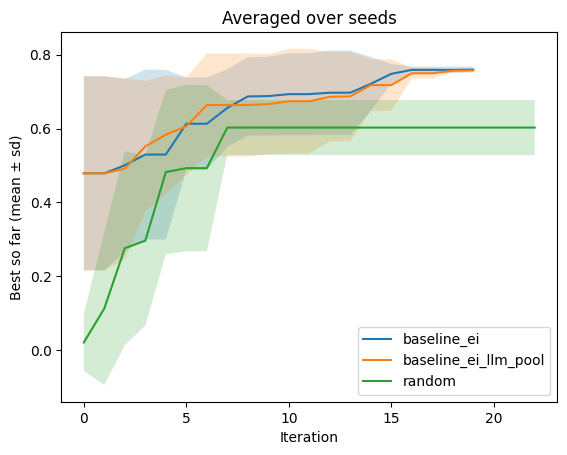

In [45]:
hist = compare_methods(n_init=3, n_iter=20, seed=8635508,repeats=3,obj=franke_hard_torch,include_hybrid=False,include_llm_pool=True)
plot_runs_mean(hist)


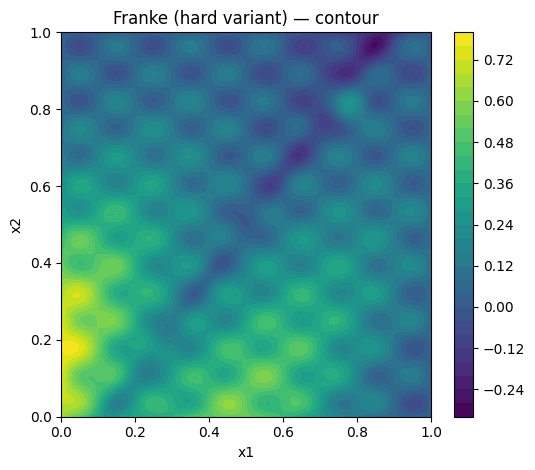

In [27]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_franke_hard(grid_n: int = 201,
                     rotate_deg: float = 35.0,
                     anisotropy=(1.0, 0.35),
                     ripple_amp: float = 0.10,
                     ripple_freq=(5, 7),
                     distractor_amp: float = 0.25,
                     distractor_mu=(0.78, 0.82),
                     distractor_sigma: float = 0.035,
                     ridge_depth: float = 0.12,
                     ridge_dir=(0.8, -0.6),
                     ridge_sigma: float = 0.025):
    """Contour plot for the harder Franke variant."""
    device = torch.device("cpu")
    dtype = torch.float32

    def franke_torch(X):
        x, y = X[..., 0], X[..., 1]
        t1 = 0.75 * torch.exp(-(9*x - 2)**2 / 4.0 - (9*y - 2)**2 / 4.0)
        t2 = 0.75 * torch.exp(-(9*x + 1)**2 / 49.0 - (9*y + 1)**2 / 10.0)
        t3 = 0.50 * torch.exp(-(9*x - 7)**2 / 4.0 - (9*y - 3)**2 / 4.0)
        t4 = 0.20 * torch.exp(-(9*x - 4)**2 - (9*y - 7)**2)
        return (t1 + t2 + t3 - t4)

    def rotate_anisowarp(X, center=(0.5, 0.5), deg=35.0, scale=(1.0, 0.35)):
        cx, cy = center
        th = math.radians(deg)
        R = torch.tensor([[math.cos(th), -math.sin(th)],
                          [math.sin(th),  math.cos(th)]], device=device, dtype=dtype)
        S = torch.tensor([[scale[0], 0.0],[0.0, scale[1]]], device=device, dtype=dtype)
        Xc = X - torch.tensor([cx, cy], device=device, dtype=dtype)
        return (Xc @ R.t()) @ S.t() + torch.tensor([cx, cy], device=device, dtype=dtype)

    # grid
    xs = torch.linspace(0, 1, grid_n, dtype=dtype, device=device)
    xx, yy = torch.meshgrid(xs, xs, indexing="xy")
    XY = torch.stack([xx, yy], dim=-1)              # (N,N,2)

    # 1) warp then base Franke
    Xw = rotate_anisowarp(XY, deg=rotate_deg, scale=anisotropy)
    base = franke_torch(Xw)

    # 2) ripples (many local optima)
    kx, ky = ripple_freq
    rip = ripple_amp * torch.sin(2*math.pi*kx*XY[...,0]) * torch.sin(2*math.pi*ky*XY[...,1])

    # 3) sharp distractor peak
    mu = torch.tensor(distractor_mu, device=device, dtype=dtype)
    dist = distractor_amp * torch.exp(-0.5 * torch.sum(((XY - mu)/distractor_sigma)**2, dim=-1))

    # 4) thin ridge valley
    v = torch.tensor(ridge_dir, device=device, dtype=dtype)
    v = v / torch.norm(v)
    proj = torch.sum((XY - 0.5) * v, dim=-1)
    ridge = -ridge_depth * torch.exp(-0.5 * (proj / ridge_sigma)**2)

    Z = (base + rip + dist + ridge).cpu().numpy()

    # plot
    fig, ax = plt.subplots(figsize=(5.5, 4.8))
    cs = ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z, levels=30)
    fig.colorbar(cs, ax=ax)
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax.set_title("Franke (hard variant) — contour")
    plt.tight_layout()
    return fig, ax

# call it
fig, ax = plot_franke_hard(grid_n=201)
